#Лабораторная работа №1
Градиентный спуск и его модификации
  1. Выбрать тестовые функции оптимизации (2 шт)
  2. Запрограммировать собственную реализацию классического градиентного спуска
  3. Запрограммировать пайлайн тестирования алгоритма оптимизации
      *   Визуализации функции и точки оптимума
      *   Вычисление погрешности найденного решения в сравнение с аналитическим для нескольких запусков
      *   Визуализации точки найденного решения
  4. Запрограммировать метод вычисления градиента
      *  Передача функции градиента от пользователя
      *  Символьное вычисление градиента
  5. Запрограммировать одну моментную модификацию и протестировать ее
  6. Запрограммировать одну адаптивную модификацию и протестировать ее
  7. Запрограммировать метод эволюции темпа обучения и протестировать

In [9]:
from matplotlib import pyplot as plt
import numpy as np
from numpy import linalg as la
from datetime import datetime
from sympy.abc import x, y
from sympy import *


In [10]:
# Ищем частные производные функции Бута
f = (x * 2 * y - 7)**2 + (2 * x + y - 5)**2
print(diff(f,x))
print(diff(f,y))

8*x + 4*y*(2*x*y - 7) + 4*y - 20
4*x*(2*x*y - 7) + 4*x + 2*y - 10


In [11]:
# Ищем частные производные функции МакКормика
f =  sin(x + y) + (x - y)**2 - float(1.5) * x +  float(2.5) * y + 1
print(diff(f,x))
print(diff(f,y))

2*x - 2*y + cos(x + y) - 1.5
-2*x + 2*y + cos(x + y) + 2.5


Задаем функцию Бута

In [12]:
class Byta():
  @staticmethod
  # Функция
  def function(x):
        return (x[0] + 2 * x[1] - 7) ** 2 + (2 * x[0] + x[1] - 5) ** 2

  @staticmethod
  # Область определения
  def get_bounds():
    return np.array([[-10, -10], [10, 10]])

  @staticmethod
  # точка глобального минимума и значение в этой точке
  def get_min():
        return np.array([1., 3., 0.])

  @staticmethod
  # Градиент функции
  def gradient(x):
        return np.array([(8 * x[0] + 4 * x[1] * (2 * x[0] * x[1] - 7) + 4 * x[1] - 20), (4 * x[0] * (2 * x[0] * x[1] - 7) + 4 * x[0] + 2 * x[1] - 10)])

Задаем функцию МакКормика

In [13]:
class MakKormik():
  @staticmethod
  # Функция
  def function(x):
        return np.sin(x[0] + x[1]) + (x[0] - x[1])**2 - float(1.5) * x[0] +  float(2.5) * x[1] + 1

  @staticmethod
  # Область определения
  def get_bounds():
    return np.array([[-1.5, -3], [4, 4]])

  @staticmethod
  # точка глобального минимума и значение в этой точке
  def get_min():
        return np.array([-0.54719, -1.54719, -1.9133])

  @staticmethod
  # Градиент функции
  def gradient(x):
        return np.array([2 * x[0] - 2* x[1] + np.cos(x[0] + x[1]) - 1.5, -2 * x[0] + 2* x[1] + np.cos(x[0] + x[1]) + 2.5 ])

Визуализация функции, градиентного спуска и глобального минимума

In [14]:
def draw_result(f: callable, bounds: np.array, glob_min: np.array, history: np.array, title: str) -> None:

    """Визуализация градиентного спуска

    Args:
        f (callable): заданная функция
        bounds (np.array): область определения функции
        glob_min (np.array): глобальный минимум функции
        history (np.array): координаты точек, по которым двигался метод оптимизации
        title (str): название метода оптимизации
    """

    fig = plt.figure(figsize = (10, 10))
    ax = plt.axes(projection = '3d')

    x = np.linspace(bounds[0, 0], bounds[1, 0], 100)
    y = np.linspace(bounds[0, 1], bounds[1, 1], 100)

    x_grid, y_grid = np.meshgrid(x, y)
    z_grid = f(np.array([x_grid, y_grid]))

    ax.plot_surface(x_grid, y_grid, z_grid, cmap = 'nipy_spectral_r', alpha=0.5)
    ax.plot(history[:, 0], history[:, 1], history[:, 2], '-', c='black', alpha = 1)
    ax.scatter3D(history[0, 0], history[0, 1], history[0, 2], s=100, c="black", lw=2, ec='black', marker = 'o')
    ax.scatter3D(history[-1, 0], history[-1, 1], history[-1, 2], s=150, c="white", lw=2, ec='black', marker = 'o', alpha = 1)
    ax.scatter3D(glob_min[0], glob_min[1], glob_min[2], s=200, c="Green", ec='Green', marker = 'o', alpha = 0.7)

    np.set_printoptions(formatter={'float_kind':"{:.2f}".format})
    print(f"Начальная точка:\t{history[0]}")
    np.set_printoptions(formatter={'float_kind':"{:.2e}".format})
    print(f"Найденный минимум:\t{history[-1]}")
    print(f"Глобальный минимум:\t{glob_min}")
    print(f"Погрешность:\t{(glob_min[2]-history[-1][2])}")
    print(f"Кол-во итераций:\t{len(history)}")

    ax.set_title(title, fontsize = 12, fontweight="bold",loc="left")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

Координаты точек, по которым двигался градиентный спуск

In [15]:
def GD(
    f: callable, grad: callable, start_params: np.ndarray, glob_min: np.ndarray,
    max_iter: int = 1000, lr: float = 0.1, delta: float = 0.001
    ) -> np.array:

    """Градиентный спуск

    Args:
        f (callable): функция искуственного ландшафта
        grad (callable): градиент функции
        start_params (np.ndarray): начальная точка
        glob_min (np.ndarray): глобальный минимум функции
        max_iter (int, optional): ограничение по кол-ву итераций. Defaults to 1000.
        lr (float, optional): шаг обучения. Defaults to 0.1.
        delta (float, optional): радиус сходимости. Defaults to 0.001.

    Returns:
        np.array: Координаты точек, по которым двигался градиентный спуск
    """

    # стартовая точка
    params = start_params.copy()
    # сбор точек, по которым двигался градиентный спуск
    history = [np.array([params[0], params[1], f(params)])]
    # итерация
    step = 0
    while (step < max_iter and (history[-1][2] - glob_min[2]) > delta):

        # новое значение параметров
        params = params - lr * grad(params)

        # сохраняем результат
        history.append(np.array([params[0], params[1], f(params)]))
        step += 1

    return np.array(history)

Для функции Бута полученные значения
 0:00:00.095223
Начальная точка:	[-1.00 1.00 72.00]
Найденный минимум:	[1.32e+00 2.61e+00 2.81e-01]
Глобальный минимум:	[1.00e+00 3.00e+00 0.00e+00]
Погрешность:	-0.28078120046268473
Кол-во итераций:	10001
Для функции Бута полученные значения
 0:00:00.096613
Начальная точка:	[1.05 3.00 0.01]
Найденный минимум:	[1.30e+00 2.65e+00 2.28e-01]
Глобальный минимум:	[1.00e+00 3.00e+00 0.00e+00]
Погрешность:	-0.2281345901061243
Кол-во итераций:	10001
Для функции Бута полученные значения
 0:00:00.097373
Начальная точка:	[5.00 5.00 164.00]
Найденный минимум:	[1.32e+00 2.61e+00 2.80e-01]
Глобальный минимум:	[1.00e+00 3.00e+00 0.00e+00]
Погрешность:	-0.2796263890673216
Кол-во итераций:	10001
Для функции Бута полученные значения
 0:00:00.097905
Начальная точка:	[2.00 -6.00 338.00]
Найденный минимум:	[1.33e+00 2.60e+00 2.94e-01]
Глобальный минимум:	[1.00e+00 3.00e+00 0.00e+00]
Погрешность:	-0.2939850921760187
Кол-во итераций:	10001
Для функции Бута полученные знач

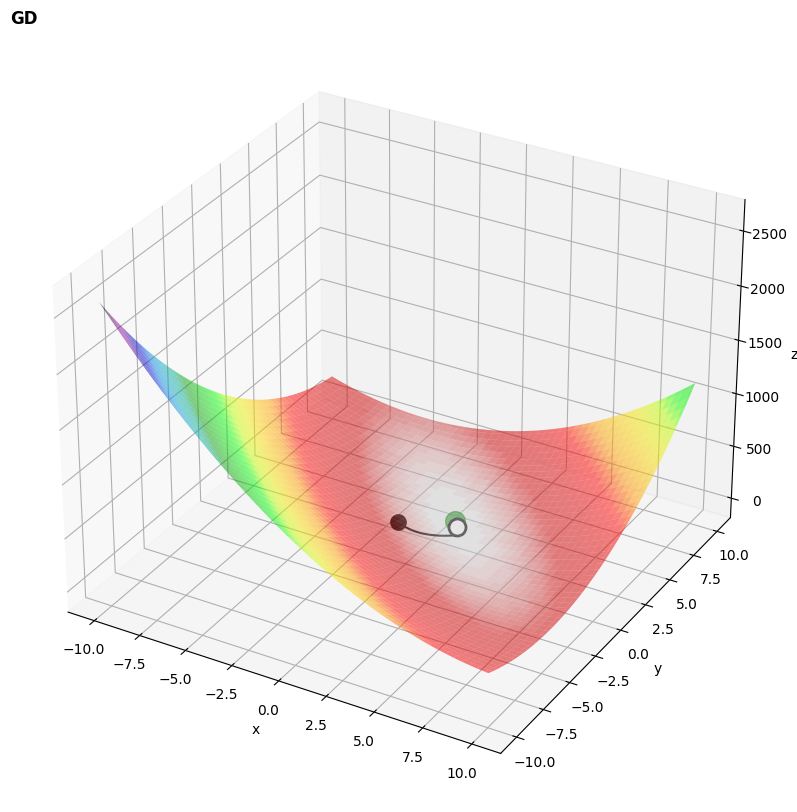

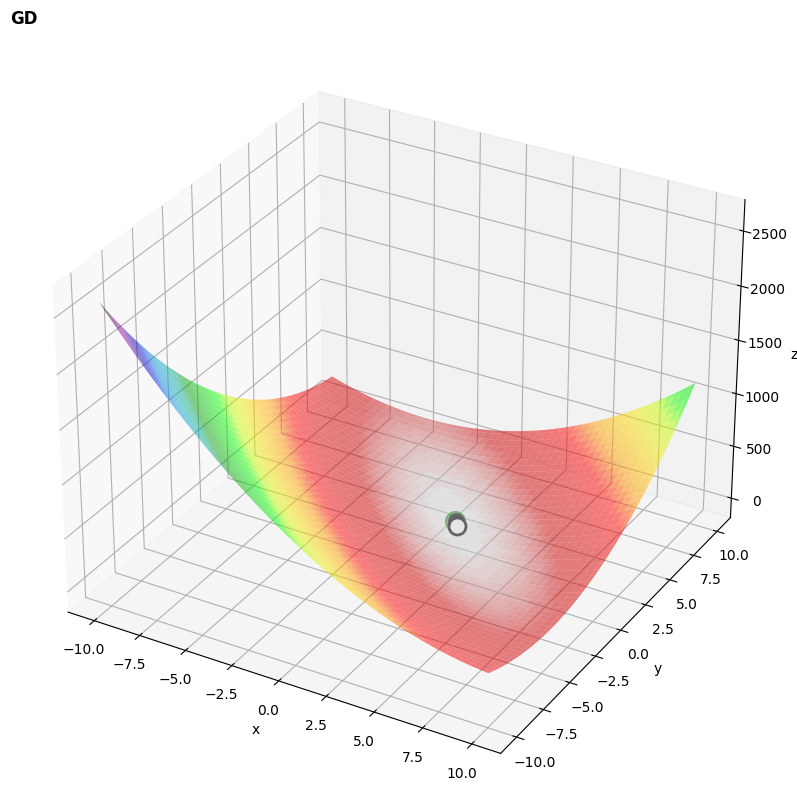

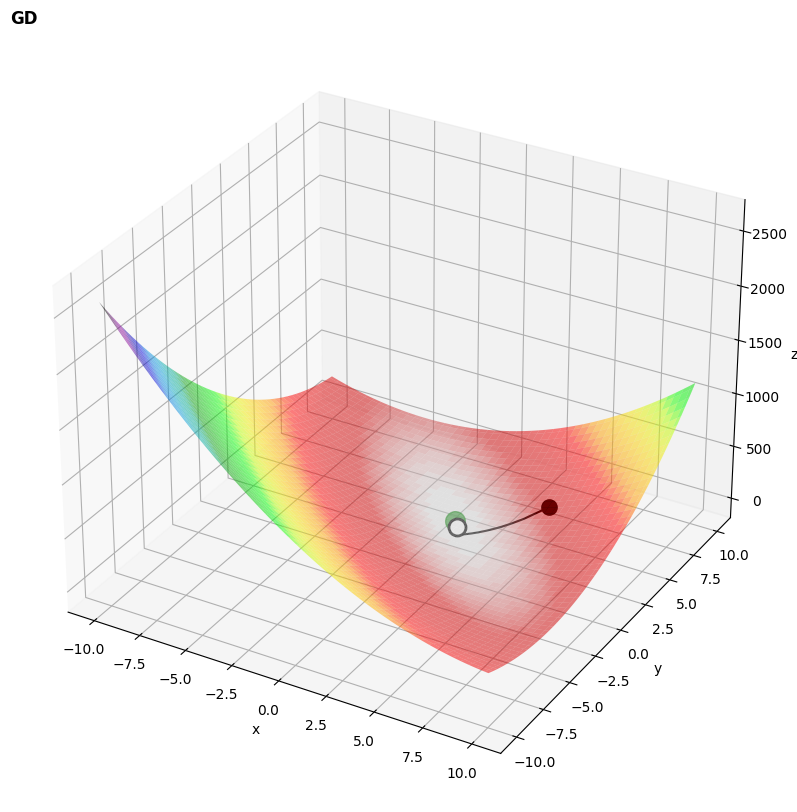

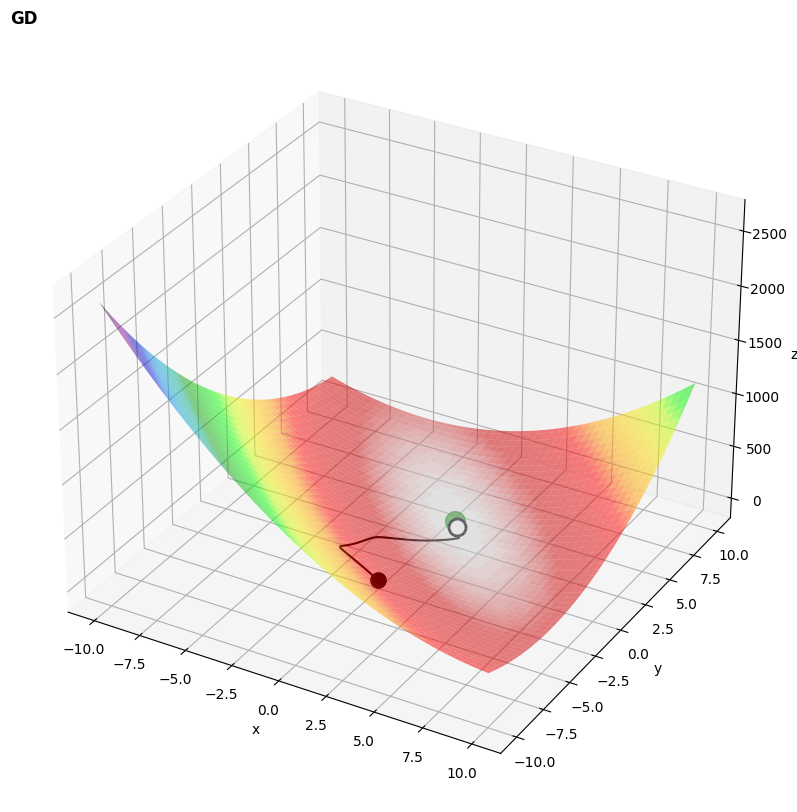

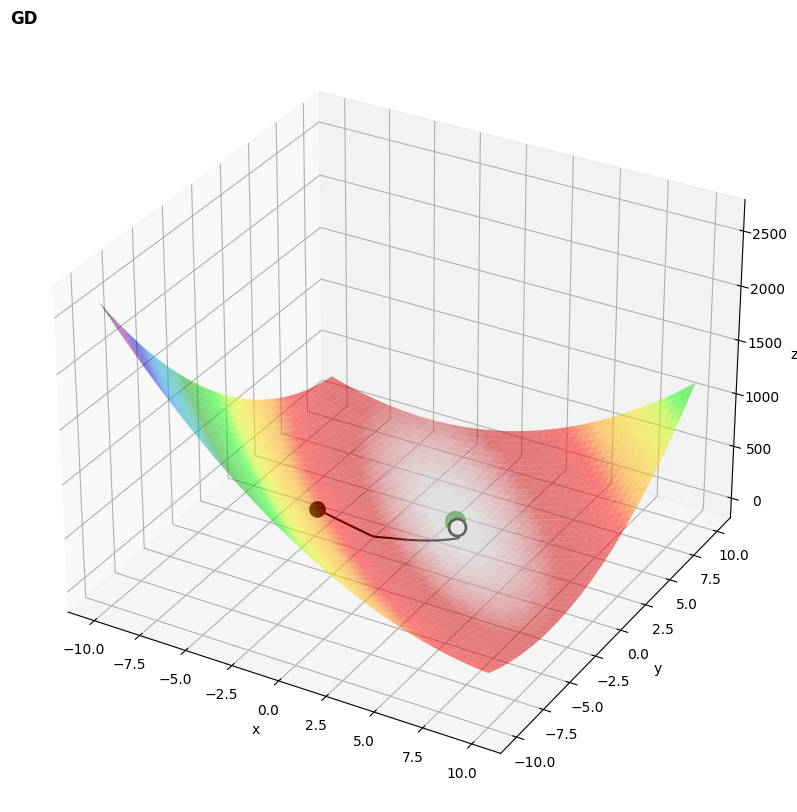

In [23]:
# Для Бута
initial_points = [[-1, 1], [1.05, 3], [5, 5], [2,-6], [-3,-3]]
for i in initial_points:
  start_time = datetime.now()
  history = GD(Byta.function, Byta.gradient, i, Byta.get_min(), max_iter = 10000, lr = 0.001, delta=0.00001)
  print("Для функции Бута полученные значения\n", datetime.now() - start_time)
  draw_result(Byta.function, Byta.get_bounds(), Byta.get_min(), history, "GD")


Точка минимума при выполнении градиентного спуска попадет не совсем туда, в этой области слабое изменение значения функции, возможно, из-за этого

Для функции МакКормика полученные значения
 0:00:00.135593
Начальная точка:	[-9.00 5.00 223.76]
Найденный минимум:	[-5.70e-01 -1.57e+00 -1.91e+00]
Глобальный минимум:	[-5.47e-01 -1.55e+00 -1.91e+00]
Погрешность:	-0.0009969964040759116
Кол-во итераций:	3329
Для функции МакКормика полученные значения
 0:00:00.048156
Начальная точка:	[-1.00 -1.00 -0.91]
Найденный минимум:	[-5.51e-01 -1.52e+00 -1.91e+00]
Глобальный минимум:	[-5.47e-01 -1.55e+00 -1.91e+00]
Погрешность:	-0.0009965935198881226
Кол-во итераций:	898
Для функции МакКормика полученные значения
 0:00:00.130922
Начальная точка:	[0.00 1.00 5.34]
Найденный минимум:	[-5.24e-01 -1.52e+00 -1.91e+00]
Глобальный минимум:	[-5.47e-01 -1.55e+00 -1.91e+00]
Погрешность:	-0.0009974043642482222
Кол-во итераций:	2480
Для функции МакКормика полученные значения
 0:00:00.219877
Начальная точка:	[2.00 2.00 2.24]
Найденный минимум:	[2.59e+00 1.59e+00 1.23e+00]
Глобальный минимум:	[-5.47e-01 -1.55e+00 -1.91e+00]
Погрешность:	-3.141669698608757
Кол-во и

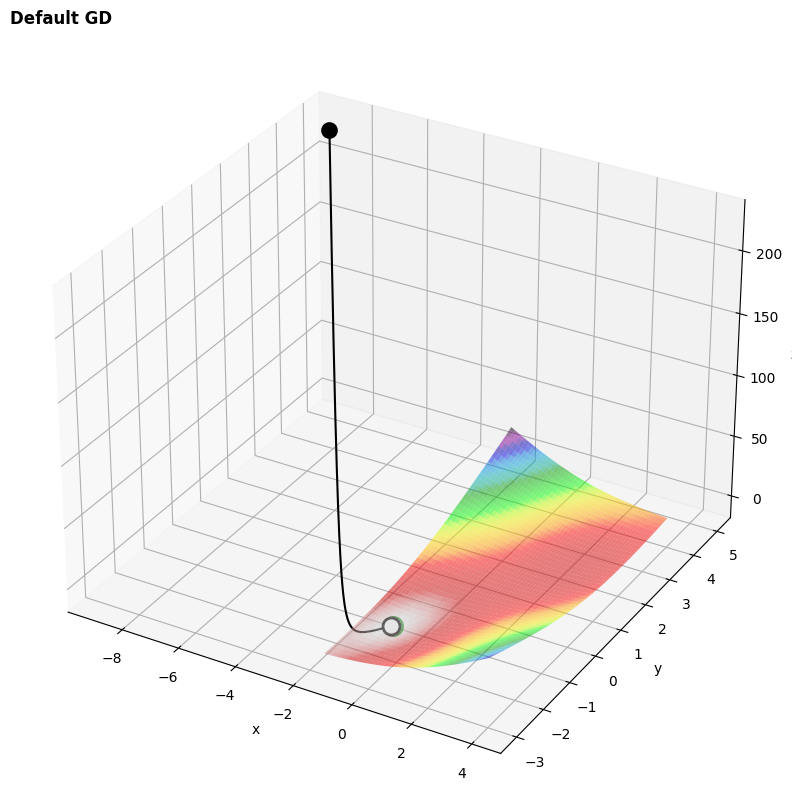

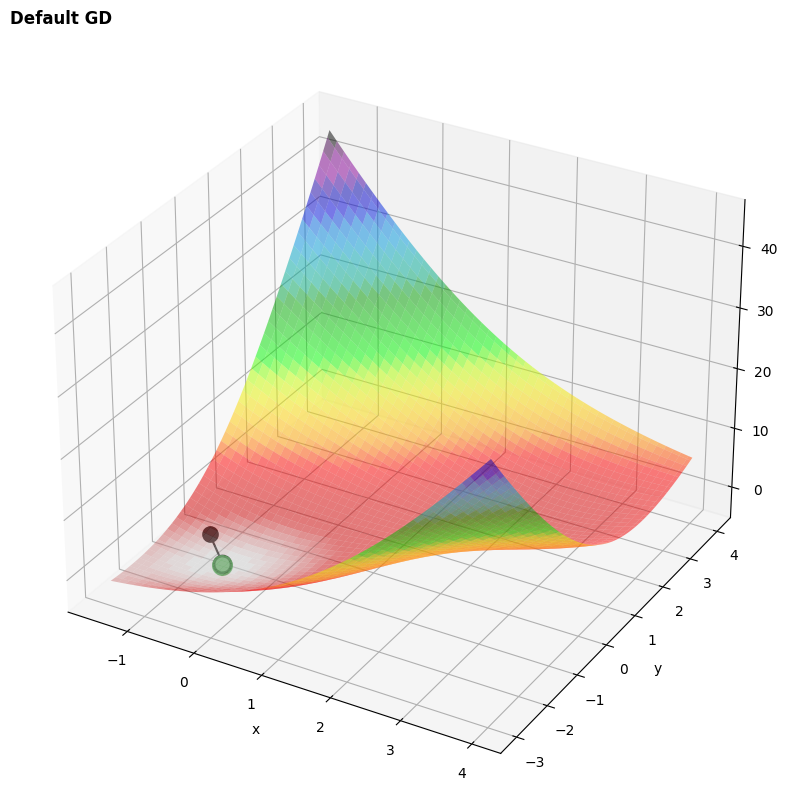

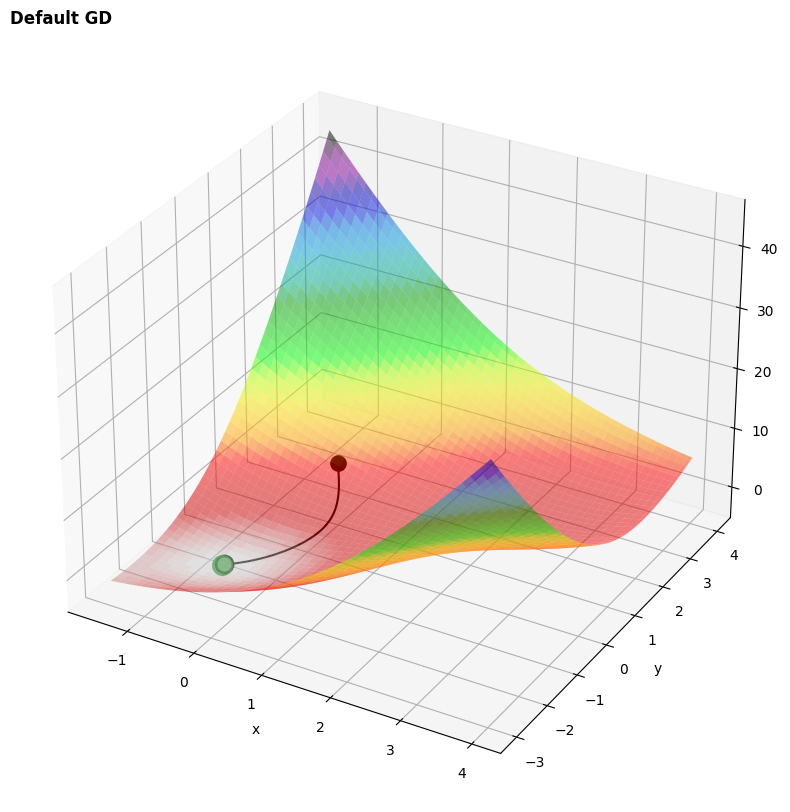

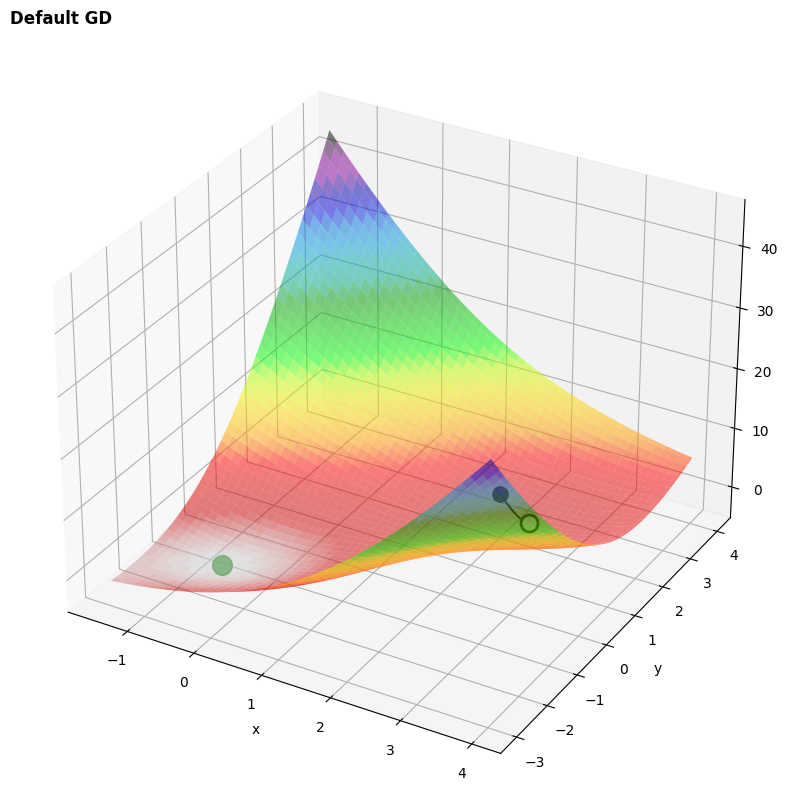

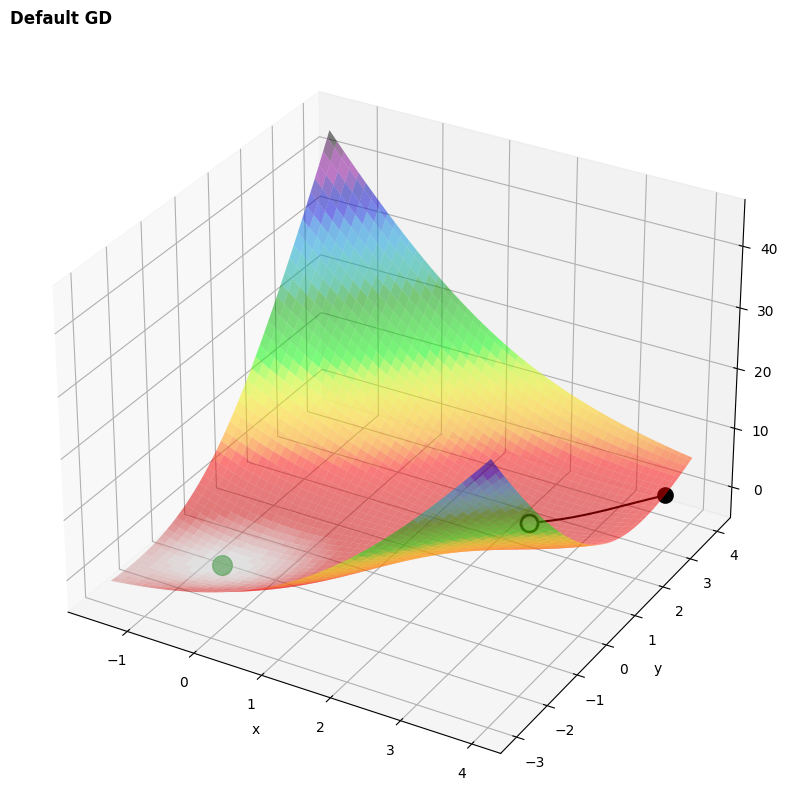

In [21]:
# Для МакКормика
initial_points = [[-9, 5], [-1, -1], [0, 1], [2,2], [4,3]]
for i in initial_points:
  start_time = datetime.now()
  history = GD(MakKormik.function, MakKormik.gradient, i, MakKormik.get_min(), max_iter = 10000, lr = 0.001)
  print("Для функции МакКормика полученные значения\n", datetime.now() - start_time)
  draw_result(MakKormik.function, MakKormik.get_bounds(), MakKormik.get_min(), history, "Default GD")

Если стартовая точка находится с нужной стороны, то попадает в глобальный минимум, иначе - в локальный

Моментная модификация GD

In [25]:
def momentum_GD(
    f: callable, grad: callable, start_params: np.ndarray, glob_min: np.ndarray,
    max_iter: int = 1000, lr: float = 0.1, delta: float = 0.001, beta: float = 0.5
    ) -> np.array:

    """Градиентный спуск с моментной модификацией

    Args:
        f (callable): заданная функция
        grad (callable): градиент функции
        start_params (np.ndarray): начальная точка
        glob_min (np.ndarray): глобальный минимум рассматриваемой функции
        max_iter (int, optional): ограничение по кол-ву итераций. Defaults to 1000.
        lr (float, optional): шаг обучения. Defaults to 0.1.
        delta (float, optional): радиус сходимости. Defaults to 0.001.
        beta (float, optional): Коэффициент энертности. Defaults to 0.5.

    Returns:
        np.array: точки, по которым двигалась моментная модификация градиентного спуска
    """

    # начальная точка
    params_prev = start_params.copy()
    params = start_params.copy()
    # точки, по которым двигалась моментная модификация градиентного спуска
    history = [np.array([params[0], params[1], f(params)])]
    # итерация
    step = 0
    while (step < max_iter and la.norm(history[-1] - glob_min) > delta):

        # вычисляем значение новых координаты исходя из значений
        # предыдущих и настоящих
        params_new = params - lr * grad(params) + beta * (params - params_prev)
        params_prev = params
        params = params_new

        # сохраняем результат
        history.append(np.array([params[0], params[1], f(params)]))
        step += 1

    return np.array(history)

Для функции Бута полученные значения
 0:00:00.217541
Начальная точка:	[5.00 5.00 164.00]
Найденный минимум:	[1.32e+00 2.62e+00 2.59e-01]
Глобальный минимум:	[1.00e+00 3.00e+00 0.00e+00]
Погрешность:	-0.2585909448924087
Кол-во итераций:	10001


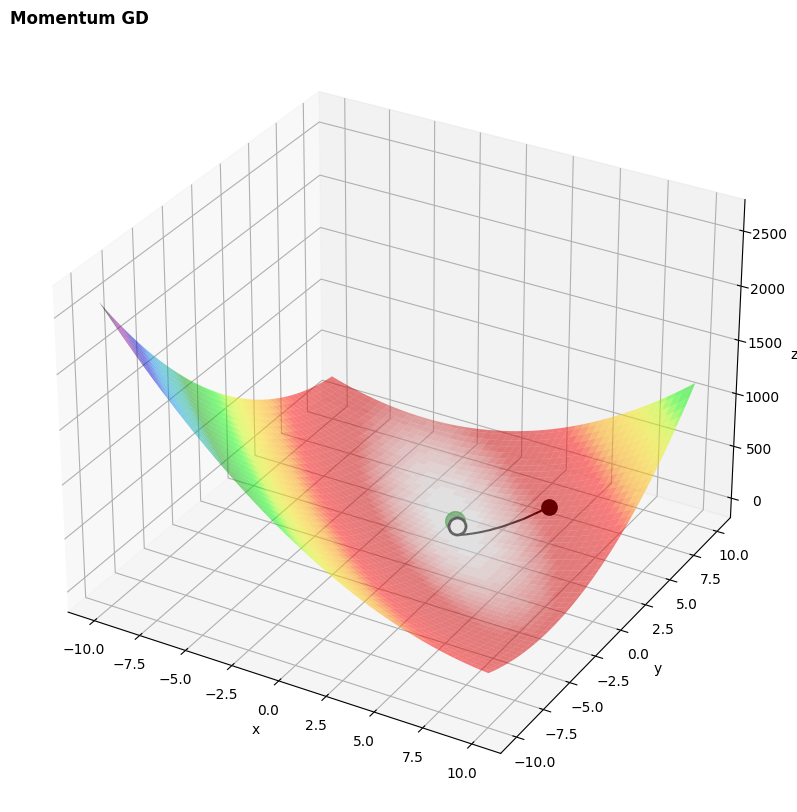

In [27]:
# Для Буту
start_time = datetime.now()
history = momentum_GD(Byta.function, Byta.gradient, np.array([5,5]), Byta.get_min(), max_iter = 10000, lr = 0.001, delta=0.00001, beta = 0.3)
print("Для функции Бута полученные значения\n", datetime.now() - start_time)
draw_result(Byta.function, Byta.get_bounds(), Byta.get_min(), history, "Momentum GD")

Опять же попали в ту же самую точку, даже изменяя коэфциент энерности

Для функции МакКормика полученные значения
 0:00:00.012915
Начальная точка:	[-1.00 1.00 9.00]
Найденный минимум:	[-5.48e-01 -1.55e+00 -1.91e+00]
Глобальный минимум:	[-5.47e-01 -1.55e+00 -1.91e+00]
Погрешность:	-7.789935471835818e-05
Кол-во итераций:	300


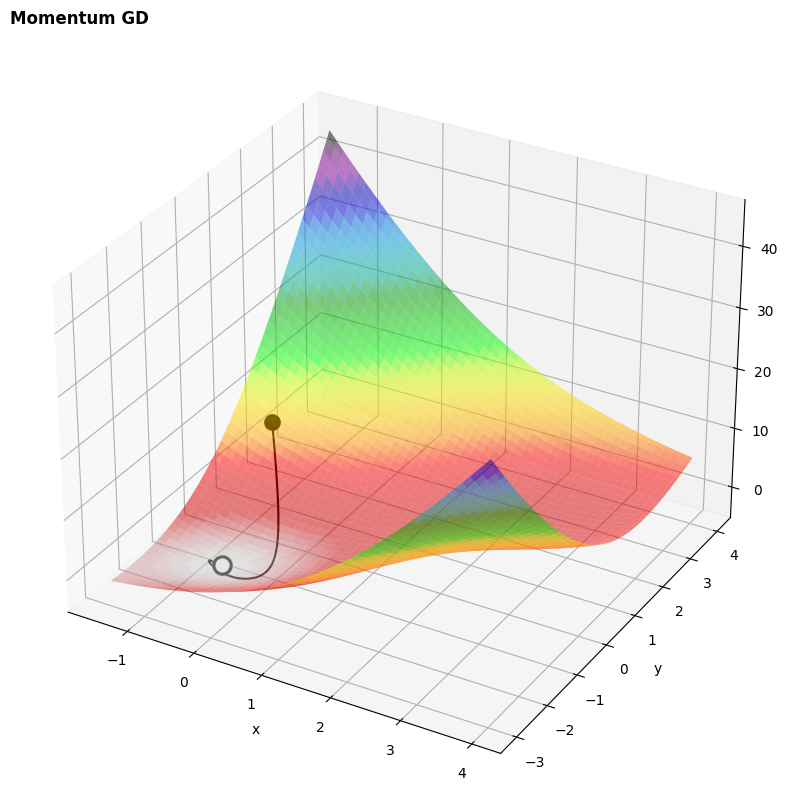

In [28]:
# Для МакКормика
start_time = datetime.now()
history = momentum_GD(MakKormik.function, MakKormik.gradient, np.array([-1,1]), MakKormik.get_min(), max_iter = 10000, lr = 0.001, beta = 0.95)
print("Для функции МакКормика полученные значения\n", datetime.now() - start_time)
draw_result(MakKormik.function, MakKormik.get_bounds(), MakKormik.get_min(), history, "Momentum GD")

Заметное уменьшение количества итераций, относительно градиентного спуска

Адаптивный метод градиентного спуска, был выбран метод Adam

In [29]:
def Adam_GD(
    f: callable, grad: callable, start_params: np.ndarray, glob_min: np.ndarray, max_iter: int = 1000,
    lr: float = 0.1, b1: float = 0.9, b2: float = 0.999, e: float = 10e-8, delta: float = 0.001
    ) -> np.array:

    """Адаптивный градиентный спуск: Adam

    Args:
        f (callable): заданная функция
        grad (callable): градиент функции
        start_params (np.ndarray): начальная точка
        glob_min (np.ndarray): глобальный минимум рассматриваемой функции
        max_iter (int, optional): Ограничение по кол-ву итераций. Defaults to 1000.
        lr (float, optional): шаг обучения. Defaults to 0.1.
        b1 (float, optional): параметр beta1. Defaults to 0.9.
        b2 (float, optional): параметр beta2. Defaults to 0.999.
        e (float, optional): "бесконечно" малое число, чтобы не было деления на 0 случайно. Defaults to 10e-8.
        delta (float, optional): радиус сходимости. Defaults to 0.001.

    Returns:
        np.array: точки, по которым двигалась моментная модификация градиентного спуска
    """

    # начальная точка
    params = start_params.copy()
    # точки, по которым двигалась моментная модификация градиентного спуска
    history = [np.array([params[0], params[1], f(params)])]
    # инициализация моментов
    m = np.array([0, 0])
    v = np.array([0, 0])
    # итерация
    step = 0
    while (step < max_iter and la.norm(history[-1] - glob_min) > delta):

        # считаем моменты
        m = b1 * m + (1 - b1) * grad(params)
        v = b2 * v + (1 - b2) * grad(params) ** 2
        # новое значение параметров
        params = params - lr * m / (np.sqrt(v) + e)
        # сохраняем результат
        history.append(np.array([params[0], params[1], f(params)]))
        step += 1

    return np.array(history)

Для функции Бута полученные значения
 0:00:00.411792
Начальная точка:	[5.00 5.00 164.00]
Найденный минимум:	[1.31e+00 2.63e+00 2.51e-01]
Глобальный минимум:	[1.00e+00 3.00e+00 0.00e+00]
Погрешность:	-0.251225597985345
Кол-во итераций:	10001


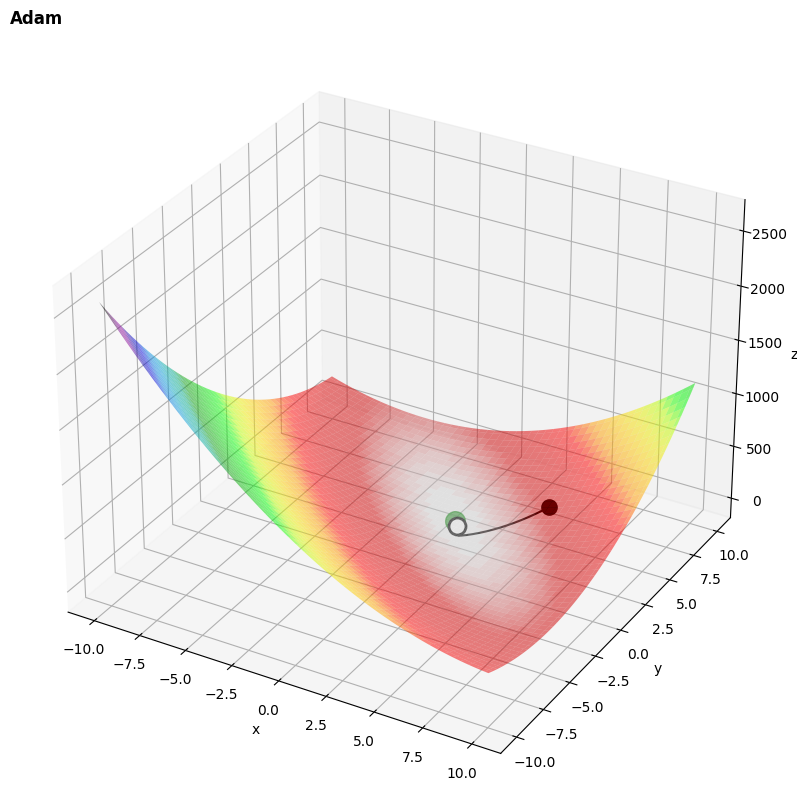

In [31]:
# Для Бута
start_time = datetime.now()
history = Adam_GD(Byta.function, Byta.gradient, np.array([5,5]), Byta.get_min(), max_iter = 10000, lr = 0.01)
print("Для функции Бута полученные значения\n", datetime.now() - start_time)
draw_result(Byta.function, Byta.get_bounds(), Byta.get_min(), history, "Adam")

И вновь мы в той же точке

Для функции МакКормика полученные значения
 0:00:00.008865
Начальная точка:	[-1.00 -3.00 -0.24]
Найденный минимум:	[-5.47e-01 -1.55e+00 -1.91e+00]
Глобальный минимум:	[-5.47e-01 -1.55e+00 -1.91e+00]
Погрешность:	-7.728184406863292e-05
Кол-во итераций:	109


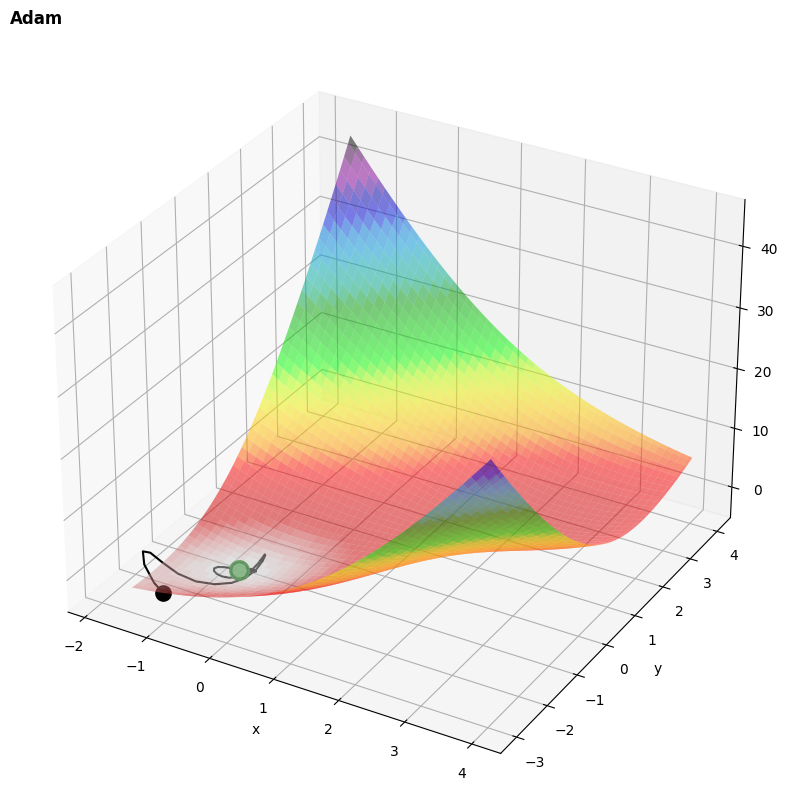

In [32]:
# Для МакКормика
start_time = datetime.now()
history = Adam_GD(MakKormik.function, MakKormik.gradient, np.array([-1,-3]), MakKormik.get_min(), max_iter = 1000, lr = 0.1)
print("Для функции МакКормика полученные значения\n", datetime.now() - start_time)
draw_result(MakKormik.function, MakKormik.get_bounds(), MakKormik.get_min(), history, "Adam")

Попали в глобальный минимум, минимальное количество итераций из 3 методов

Поиск точки глобального минимума для введенной пользователем функции

In [33]:
# Получение значения введеной функции
def function(fx):
  x, y = symbols('x y')
  gfg = sympify(Func)
  substitutions = {x: fx[0], y: fx[1]}
  return float(gfg.subs(substitutions))

In [35]:
# Функции определения функции, глоббльный минимум (задан рандомно, так как аналитическим способом
# введенную функцию не решить), градиент функции
def get_bounds(xy_min):
  return np.array([[xy_min[0] - 10, xy_min[1] - 10], [xy_min[0] + 10, xy_min[1] + 10]])

def get_min():
      return np.array([0., 0., 0.])

def gradient(xy):
  x, y = symbols('x y')
  gfg = sympify(Func)
  substitutions = {x: xy[0], y: xy[1]}
  diffX = diff(gfg, x)
  diffY = diff(gfg, y)
  return np.array([float(diffX.subs(substitutions)), float(diffY.subs(substitutions))])

In [36]:
# Визуализация функции и точки оптимума
def draw_result_func(func: callable, history: np.array) -> None:
  fig = plt.figure(figsize=(10,10))
  ax = plt.axes(projection = '3d')
  x = np.linspace(-10, 10, 100)
  y = np.linspace(-10, 10, 100)
  x_grid, y_grid = np.meshgrid(x,y)
  z = []
  for i in range(len(x)):
    a = func(np.array([x[i], y[i]]))
    z.append(a)

  z_grid=np.asarray(np.meshgrid(z))
  ax.plot_surface(x_grid, y_grid, z_grid, cmap = 'nipy_spectral_r', alpha=0.5)
  ax.plot(history[:, 0], history[:, 1], history[:, 2], '-', c='black', alpha = 1)
  ax.scatter3D(history[0, 0], history[0, 1], history[0, 2], s=100, c="black", lw=2, ec='black', marker = 'o')
  ax.scatter3D(history[-1, 0], history[-1, 1], history[-1, 2], s=150, c="white", lw=2, ec='black', marker = 'o', alpha = 1)


Введите выражение, переменные задавайте в виде x, y: x**2 + y**2 + x*y
Полученные значения введеной вашей функции
 0:00:10.099467
[1.82e-02 1.82e-02 9.94e-04]


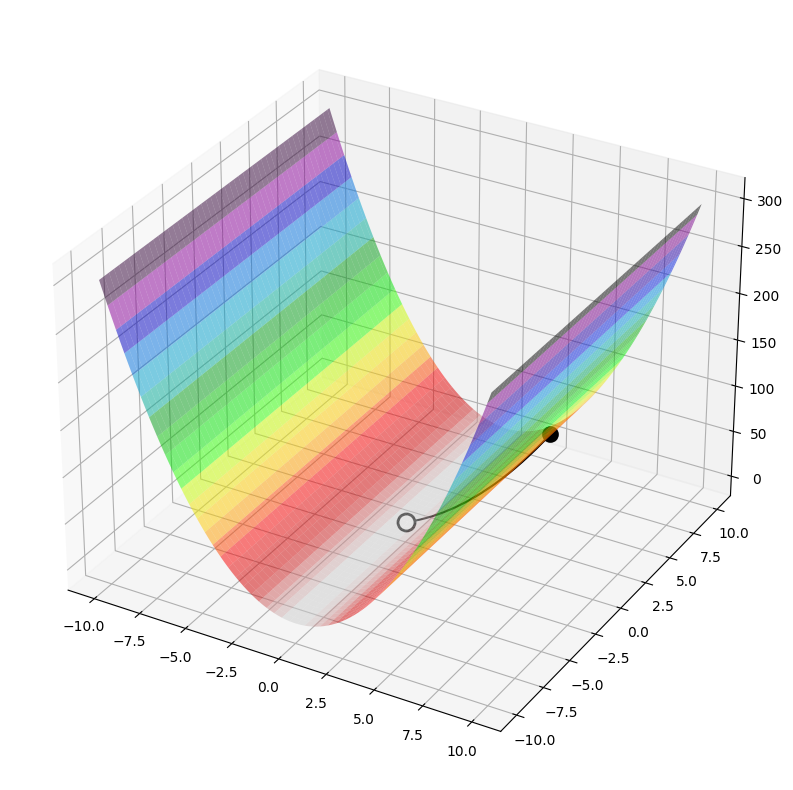

In [37]:
# Задаем символами для sympy x и y
x, y = symbols('x y')
# делаем переменную, в которой введеная функция становится глобальной, чтобы все методы могл к ней обращаться
global Func
expn = input("Введите выражение, переменные задавайте в виде x, y: ")
Func = expn
# Преобразуем введенную функцию с помощью sympy в читабульный вид
gfg = sympify(expn)
start_time = datetime.now()
history = GD(function, gradient, np.array([5,5]), get_min(), max_iter = 10000, lr = 0.001)
print("Полученные значения введеной вашей функции\n", datetime.now() - start_time)
print(history[-1])
draw_result_func(function, history)

Добавим в градиентный спуск метод эволюции темпа

In [47]:
def GD_LR(
    f: callable, grad: callable, start_params: np.ndarray, glob_min: np.ndarray, lr: [],
    max_iter: int = 1000, delta: float = 0.001
    ) -> np.array:

    """Градиентный спуск

    Args:
        func (callable): заданная функция
        grad (callable): градиент функции
        start_params (np.ndarray): начальная тчока
        glob_min (np.ndarray): глобальный минимум рассматриваемой функции
        lr ([]): массивов из шагов обучения, где шаг постепенно уменьшается
        max_iter (int, optional): ограничение по кол-ву итераций. Defaults to 1000.
        delta (float, optional): радиус сходимости. Defaults to 0.001.

    Returns:
        np.array: точки, по которым двигался градиентный спуск
    """

    # начальная точка
    params = start_params.copy()
    history = [np.array([params[0], params[1], f(params)])]

    step = 0
    while (step < max_iter and (history[-1][2] - glob_min[2]) > delta):

        # новое значение параметров
        # каждый раз подставляем новый шаг
        params = params - lr[step] * grad(params)

        # сохраняем результат
        history.append(np.array([params[0], params[1], f(params)]))
        step += 1

    return np.array(history)

In [45]:
# Экспоециональный метод уменьшения шага
def exponential_decay(initial_lr, decay_rate, iteration):
  """уменьшение шага

  Args:
    initial_lr: начальный шаг
    decay_rate: скорость изменения шага
    iteration: количество итераций

  Returns:
    []: шаг на каждой итерации
  """
  lr = []
  for i in range(iteration):
  # Обновление шага
    lr.append(initial_lr * (decay_rate ** i))
  return lr

Для функции МакКормика полученные значения
 0:00:00.000626
Начальная точка:	[-1.00 1.00 9.00]
Найденный минимум:	[-5.34e-01 -1.53e+00 -1.91e+00]
Глобальный минимум:	[-5.47e-01 -1.55e+00 -1.91e+00]
Погрешность:	-0.00037560392450908253
Кол-во итераций:	7


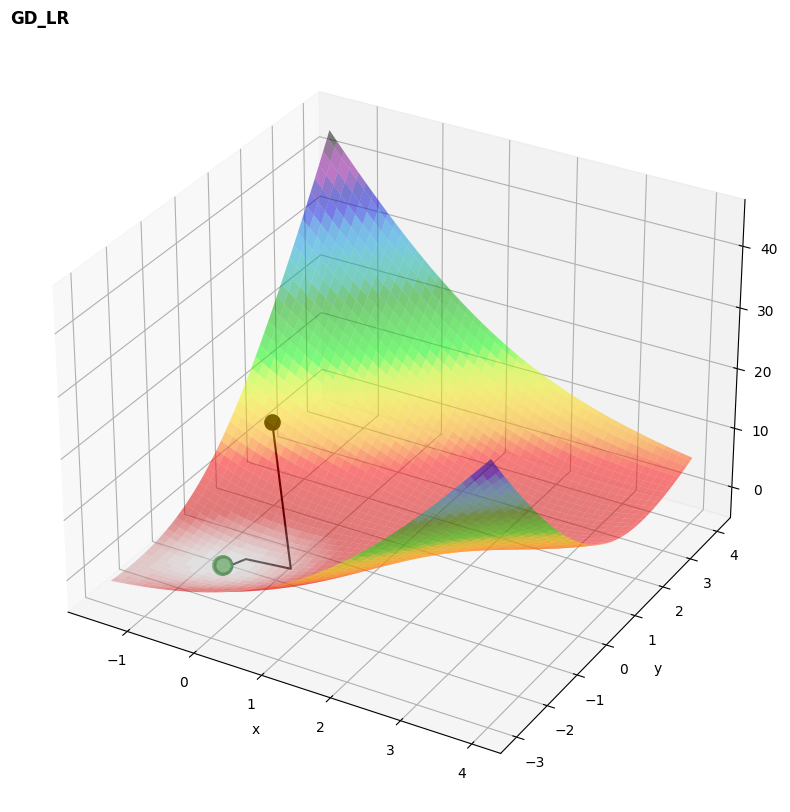

In [48]:
# Задаем список шагов
lr = exponential_decay(0.3, 0.99, 10000)
start_time = datetime.now()
history = GD_LR(MakKormik.function, MakKormik.gradient, np.array([-1,1]), MakKormik.get_min(), lr, max_iter = 10000)
print("Для функции МакКормика полученные значения\n", datetime.now() - start_time)
draw_result(MakKormik.function, MakKormik.get_bounds(), MakKormik.get_min(), history, "GD_LR")

Необычайно малое количество итераций с сохранением точности